# **Module 3:** Supervised Classification Project

Colin Beyers\
GEOL558

# Project Overview

**Title**: Classifying Sea State with Machine Learning

This project aims to classify sea states based on oceanographic variables such as significant wave height, wave period, and wind speed. Sea states are crucial for maritime activities, providing valuable information on potential hazards and navigational conditions. Machine learning (ML) is employed to automate the classification process, leveraging large datasets and complex relationships between environmental factors that are difficult to model explicitly using traditional approaches. The project uses observational data from a NOAA National Data Buoy Center (NDBC) buoy 46025, off the coast of Malibu. This buoy measures significant wave height (WVHT), wave period (DPD), and wind speed (WSPD), which are key predictors of sea state conditions. By applying ML, the project can efficiently analyze and classify sea state conditions in real-time, helping decision-makers in shipping, navigation, and coastal management.

## Imports

In [1]:
# !pip install cartopy

In [115]:
# data handling
import pandas as pd
import numpy  as np

# plotting 
import seaborn              as sbn
import matplotlib.pyplot    as pyp
import cartopy.crs          as ccrs
import cartopy.feature      as cfeature

# modeling
from sklearn.preprocessing      import StandardScaler, LabelEncoder
from sklearn.ensemble           import GradientBoostingClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.svm                import SVC
from sklearn.model_selection    import GridSearchCV
from sklearn.model_selection    import RandomizedSearchCV
from sklearn.metrics            import precision_score, recall_score, f1_score, confusion_matrix

# Data Aquisition

NDBC data can be easily accessed via an API call. An example of how to do this is below, but will not be used here. For this project, I collected the data in a separate notebook, saved, and uploaded to GitHub so others can use it easily.

In [3]:
# buoy_id = "46025" # Santa Monica Bay, CA
# year = "2023"
# url = f"https://www.ndbc.noaa.gov/view_text_file.php?filename={buoy_id}h{year}.txt.gz&dir=data/historical/stdmet/"
# df = pd.read_csv(url, delim_whitespace=True, skiprows=[1])  # first row is metadata

In [4]:
url = 'https://raw.githubusercontent.com/colinbeyers/GEOL558-submissions/refs/heads/main/module_3/NDBC_46025-wave_params-2023.csv'
df = pd.read_csv(url)

# Data Preprocessing

This dataset and buoy were chosen for a couple reasons:
- It has a wind speed measurement device
- It has WMO (World Meteorological Organization) seastate labels, which are used to classify seastate

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52519 entries, 0 to 52518
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  52519 non-null  int64  
 1   #YY         52519 non-null  int64  
 2   MM          52519 non-null  int64  
 3   DD          52519 non-null  int64  
 4   hh          52519 non-null  int64  
 5   mm          52519 non-null  int64  
 6   WDIR        52519 non-null  int64  
 7   WSPD        52519 non-null  float64
 8   GST         52519 non-null  float64
 9   WVHT        52519 non-null  float64
 10  DPD         52519 non-null  float64
 11  APD         52519 non-null  float64
 12  MWD         52519 non-null  int64  
 13  PRES        52519 non-null  float64
 14  ATMP        52519 non-null  float64
 15  WTMP        52519 non-null  float64
 16  DEWP        52519 non-null  float64
 17  VIS         52519 non-null  float64
 18  TIDE        52519 non-null  float64
 19  WMOS        52519 non-nul

The features in this dataset are:
- YY/MM/DD/hh/mm: The year, month, day, hour, and minute of the observation
- WDIR/WSPD: wind direction and speed
- GST: gust speed
- WVHT: wave height
- DPD/APD: dominant and average period
- MWD: mean wave direction
- PRES: atmospheric pressure
- ATMP/WTMP: atmospheric and water temperatures
- DEWP: dew point
- VIS: visibility
- TIDE: tide height
- WMOS: SMO sea state classification

There's a couple things I want to do with this data:
1) Drop variables that do not contribute to sea state: WDIR, MWD, GST, PRES, ATMP/WTMP, DEWP, VIS, and TIDE. I am unsure which out of DPD and APD are considered for sea state classification (WMO and NOAA's websites doesn't make this clear).
2) Rename variables to be more clear

In [6]:
df = df.drop(columns=['WDIR', 'MWD', 'GST', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'TIDE'])

In [7]:
df = df.rename(columns={
    'WDIR': 'wind_dir',
    'WSPD': 'wind_speed',
    'WVHT': 'wave_height',
    'DPD': 'dominant_period',
    'APD': 'avg_period',
    'WMOS': 'WMO_seastate'
})

In [8]:
df.describe()

,Unnamed: 0,#YY,MM,DD,hh,mm,wind_speed,wave_height,dominant_period,avg_period
count,52519.000000,52519.0,52519.000000,52519.000000,52519.000000,52519.000000,52519.000000,52519.000000,52519.000000,52519.000000
mean,26259.000000,2023.0,6.525924,15.716217,11.503589,25.000857,3.758072,66.453144,70.084279,68.134436
std,15161.073731,0.0,3.448661,8.797360,6.921193,17.077262,3.062548,46.101451,41.013649,43.726300
min,0.000000,2023.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.390000,3.450000,3.610000
25%,13129.500000,2023.0,4.000000,8.000000,6.000000,10.000000,2.100000,1.300000,14.810000,6.760000
50%,26259.000000,2023.0,7.000000,16.000000,12.000000,30.000000,3.300000,99.000000,99.000000,99.000000
75%,39388.500000,2023.0,10.000000,23.000000,18.000000,40.000000,4.800000,99.000000,99.000000,99.000000
max,52518.000000,2023.0,12.000000,31.000000,23.000000,50.000000,99.000000,99.000000,99.000000,99.000000


We have a lot of observations to work with here, however the "max" for each feature shows that many have a max of 99. This is likely used to express bad/missing data.

In [9]:
df['wave_height']

0        99.00
1         1.30
2        99.00
3        99.00
4         1.44
         ...  
52514     2.54
52515    99.00
52516    99.00
52517     2.13
52518    99.00
Name: wave_height, Length: 52519, dtype: float64

For example, `wave_height` only has actual observations every few rows. For all features, we should remove these so that they don't skew our model.

In [10]:
df = df[~df[['avg_period', 'dominant_period', 'wave_height', 'wind_speed']].isin([99]).any(axis=1)]

In [11]:
df.describe()

,Unnamed: 0,#YY,MM,DD,hh,mm,wind_speed,wave_height,dominant_period,avg_period
count,17466.000000,17466.0,17466.000000,17466.000000,17466.000000,17466.000000,17466.000000,17466.000000,17466.000000,17466.000000
mean,26271.525421,2023.0,6.528799,15.715275,11.501374,25.000000,3.720319,1.156357,12.073102,6.210802
std,15165.323685,0.0,3.449642,8.802653,6.919845,15.000429,2.400096,0.544164,3.731921,1.390330
min,1.000000,2023.0,1.000000,1.000000,0.000000,10.000000,0.000000,0.390000,3.450000,3.610000
25%,13129.750000,2023.0,4.000000,8.000000,6.000000,10.000000,2.100000,0.830000,9.090000,5.280000
50%,26290.500000,2023.0,7.000000,16.000000,11.500000,25.000000,3.200000,0.990000,12.900000,5.850000
75%,39404.250000,2023.0,10.000000,23.000000,17.000000,40.000000,4.800000,1.290000,14.810000,6.750000
max,52517.000000,2023.0,12.000000,31.000000,23.000000,40.000000,17.200000,6.150000,23.530000,13.730000


We have WAY less observations now, but there are still well over 10,000, so this dataset should still work just fine.

Last preprocessing we should do is parse the `YY`/`MM`/`DD`/`hh`/`mm` columns to a single `time` datetime object column.

In [12]:
df['time'] = pd.to_datetime(df[['#YY', 'MM', 'DD', 'hh', 'mm']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H-%M')

In [13]:
df.drop(columns=['#YY', 'MM', 'DD', 'hh', 'mm'], inplace=True)

In [14]:
df = df[['time'] + [col for col in df.columns if col != 'time']]

# Exploratory Data Analysis

## Location

While the dataset does not have the lat/lon, NOAA's website labels them as: 33.755N 119.045W.

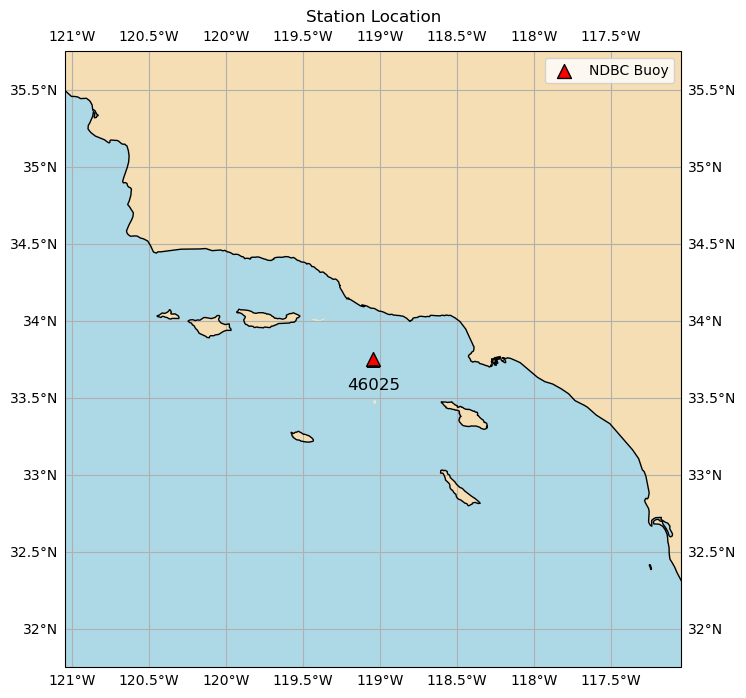

In [15]:
lat = 33.755
lon = -119.045

fig, ax = pyp.subplots(figsize=(8, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon-2, lon+2, lat-2, lat+2])

# features
ax.coastlines(resolution='10m', color='black')
ax.gridlines(draw_labels=True, zorder = 1)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAND, facecolor='wheat')

# buoy location
ax.scatter(lon, lat, 
           color='red', marker='^', edgecolor='black', 
           s=100, label='NDBC Buoy', zorder=2)
ax.text(lon, lat-0.2, '46025', ha='center', fontsize=12, color='black')

# title
ax.set_title('Station Location')
ax.legend(loc='upper right')

pyp.show()

This area is known as the Santa Barbara Channel. It is relatively shallow and sheltered. Malibu, a popular surfing location, is located directly above and a little to the right if the buoy.

# WMO Code distribution

There are 10 WMO seastate codes:
- 0: Calm (glassy)
- 1: Calm (rippled)
- 2: Smooth (wavelets)
- 3: Slight
- 4: Moderate
- 5: Rough
- 6: Very rough
- 7: High
- 8: Very high
- 9: Phenomenal

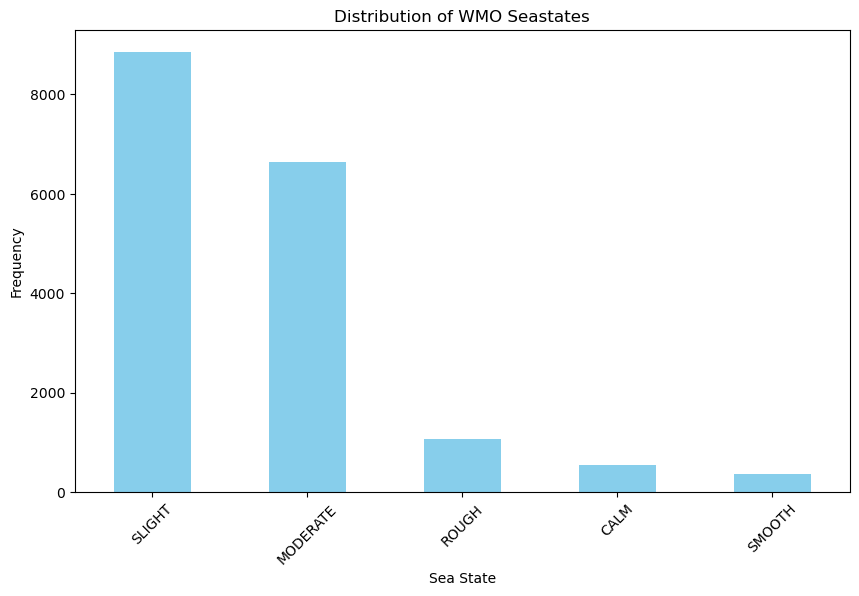

In [16]:
# Count the occurrences of each sea state
seastate_counts = df['WMO_seastate'].value_counts()

# Plot the bar graph
pyp.figure(figsize=(10, 6))
seastate_counts.plot(kind='bar', color='skyblue')
pyp.title('Distribution of WMO Seastates')
pyp.xlabel('Sea State')
pyp.ylabel('Frequency')
pyp.xticks(rotation=45)
pyp.show()

This dataset does not represent every code. The higher codes (6-9) are exceedingly rare and only every really observed in the Southern Ocean, North Atlantic, and North Pacific. It is unsurprising that in this sheltered channel, they are not observed. The 'calm' label could be 0 or 1, but I think it's probably 1. A truly glassy sea is very rare to observe; the NOAA documentations suggests that 'glassy' is used as the label for code 0. The most common code is 'sight', emphasizing the relatively calm/smooth waves that are usually found in this region.

# Feature Correlations

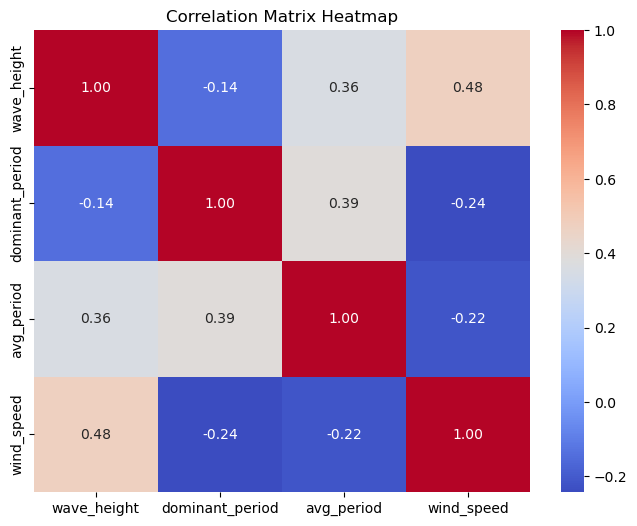

In [17]:
corr_matrix = df[['wave_height', 
                  'dominant_period', 
                  'avg_period', 
                  'wind_speed']].corr()

# Plot the heatmap
pyp.figure(figsize=(8, 6))
sbn.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
pyp.title('Correlation Matrix Heatmap')
pyp.show()

Unsurprisingly, the wind speed and wave height are somewhat positively correlated. Stronger winds = higher waves. There is also a somewhat positive correlation between wave height and average period. This shows that longer period swell waves tend to be higher than shorter waves. There is a very weak correlation between the dominant period and the wave height.

# Box and Whisker Plots

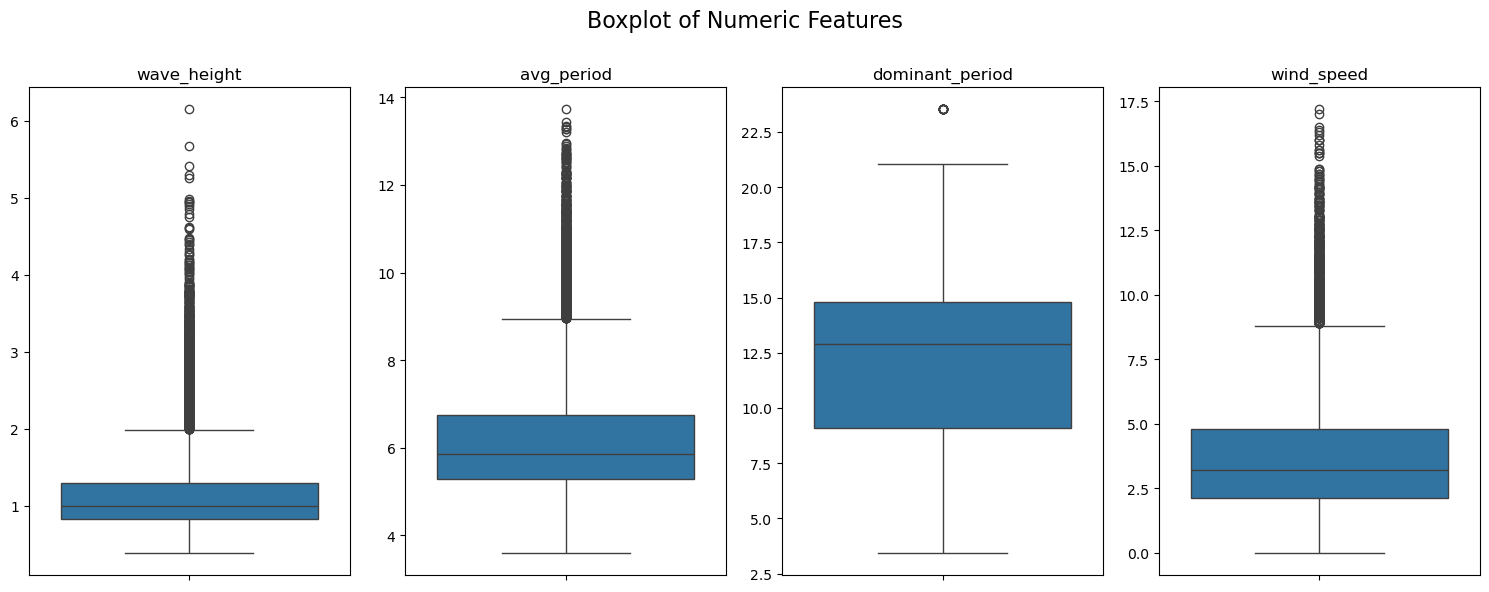

In [18]:
features = ['wave_height', 
            'avg_period', 
            'dominant_period', 
            'wind_speed']

fig, axes = pyp.subplots(nrows=1, ncols=len(features), figsize=(15, 6))

for ax, feature in zip(axes, features):
    sbn.boxplot(data=df[feature], ax=ax)
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.suptitle('Boxplot of Numeric Features', fontsize=16)

pyp.tight_layout()
pyp.subplots_adjust(top=0.85)

pyp.show()

- Wave Height: wave heights in this region are relatively small for the entire year, averaging only 1m. Even a maximum of 6m is small compared to other locations not so protected on the California coast.
- Average Period: the average period shows that most of the time, the seastate is dominated by locally generated wind waves. The maximum values >10s are likely when winds are quiet and swell is present.
- Dominant Period: this shows what period of wave has the most energy when the observation was taken. Most dominant periods are >10s, which are swell waves (what people surf). This supports Malibu being such a great surfing location! Although the average period is >10s, swell waves have more energy than wind waves, so their imprint on the dominant period is more visible.
- Wind Speed: average wind speeds in this area are relatively calm, but have the potential to be large (>10m/s) during storms.

All of these factors combined support what we see in the WMO labels - there are many instances of calmer seas. Calmer seas does not necessarily mean that the waves can't be powerful for surfing though! It just means that the waves are more organized and less "rough" (aggressive), which leads to a more pleasant beach and surfing experience.

# Wave Height Time Series

Just to visualize how wave height varies with time.

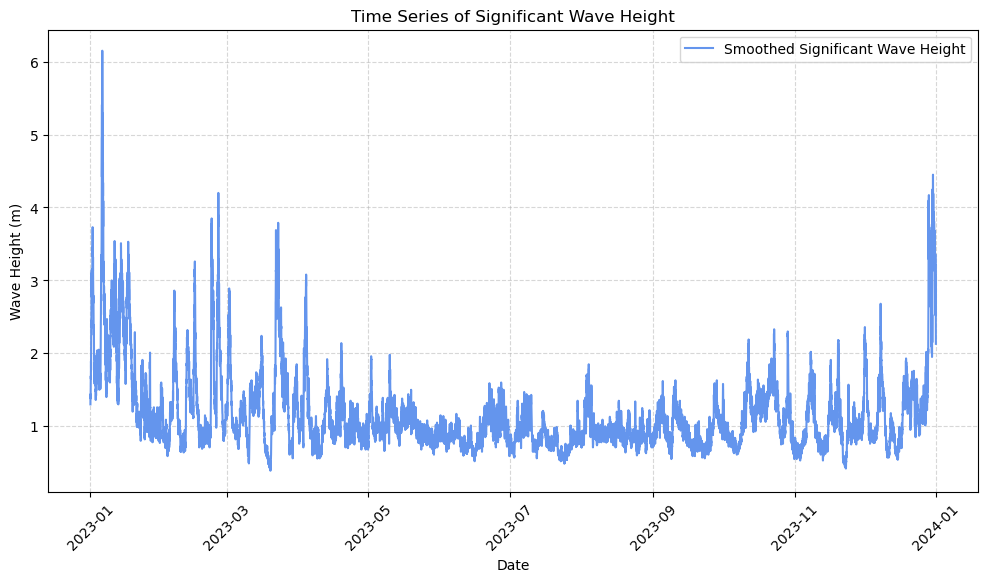

In [19]:
pyp.figure(figsize=(12, 6))
pyp.plot(df['time'], df['wave_height'], 
         color='cornflowerblue', label='Smoothed Significant Wave Height')
pyp.title('Time Series of Significant Wave Height')
pyp.xlabel('Date')
pyp.ylabel('Wave Height (m)')
pyp.xticks(rotation=45)
pyp.grid(True, linestyle='--', alpha=0.5)
pyp.legend()
pyp.show()

# First Pass

## Feature Engineering

Before training a model, we need to do a few things:
- Standardize the data (so no feature dominates the model based on scale)
- Split the features and target variables
- Encode the WMO codes to numbers
- Split the data for testing and training

### 1. Split the data temporally (the data is sorted by time)

As pointed out by Rhys, I need to first split my data before standardizing to avoid data leakage (thanks!).

In [69]:
train_size = int(0.8 * len(df))  # 80% for training, 20% for testing
train_data = df[:train_size]
test_data = df[train_size:]

In [70]:
target = 'WMO_seastate'

In [71]:
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

### 2. Normalize the features using StandardScaler

In [72]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)

### 3. Encode the target variable `WMO_seastate`

In [73]:
target = 'WMO_seastate'
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test  = label_encoder.fit_transform(y_test)

In [74]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'CALM': 0, 'MODERATE': 1, 'ROUGH': 2, 'SLIGHT': 3, 'SMOOTH': 4}


## Logistical Regression

We can first throw our data into the least complex model and see what happens.

### Train

In [75]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Predict

In [76]:
y_pred = model.predict(X_test)

### Evaluate

The 4 evaluation metrics I will be using are:
- **Precision**: measures the proportion of correctly predicted instances among all instances classified as a given category, indicating how many of the positive predictions were actually correct.  
- **Recall**: measures the proportion of correctly predicted instances out of all actual instances in that category, reflecting the model’s ability to identify all relevant cases.  
- **F1 Score**: the harmonic mean of precision and recall, providing a balanced metric when both false positives and false negatives are important.  
- **Confusion Matrix**: a table that summarizes the number of correct and incorrect predictions for each class, helping to visualize the model's performance across categories.  

A **weighted score** calculates the overall metric by averaging individual class scores, weighted by the number of true instances in each class, ensuring that larger classes contribute proportionally more to the final score.

In [77]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [78]:
print(f"Precision (weighted): {precision:.3f}")
print(f"Recall (weighted): {recall:.3f}")
print(f"F1 Score (weighted): {f1:.3f}")

Precision (weighted): 0.848
Recall (weighted): 0.841
F1 Score (weighted): 0.831


- Precision: out of all the instances the model predicted a specific sea state, 77.2% of those predictions were actually correct.
- Recall: This shows that the model was able to correctly identify 78.7% of all actual sea state instances across all classes.
- F1 Score: This suggests that the model's performance is reasonably balanced in both identifying true positives and avoiding false positives, with a slight favor towards recall.

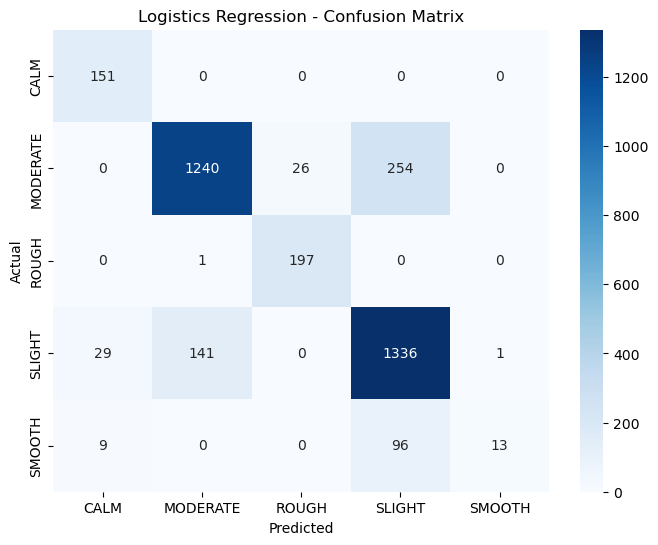

In [79]:
cm = confusion_matrix(y_test, y_pred)

pyp.figure(figsize=(8, 6))
sbn.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
pyp.title('Logistics Regression - Confusion Matrix')
pyp.xlabel('Predicted')
pyp.ylabel('Actual')
pyp.show()

- The model performs well for CALM, MODERATE, SLIGHT, and SMOOTH, with high accuracy.
- The main confusion arises between CALM and SLIGHT, and SLIGHT with MODERATE.
- ROUGH is predicted with lower accuracy, possibly due to its relatively small representation in the dataset.

There are not really parameters to tune for this type of model, so I will try 2 more complex models: Gradient Boosting and Support Vector Machine.

## Gradient Boosting

We will just use the default parameters first. This is an ensemble method.

### Train

In [80]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

### Predict

In [81]:
y_pred_gb = gb_model.predict(X_test)

### Evaluate

In [82]:
precision_gb = precision_score(y_test, y_pred_gb, average='weighted')
recall_gb = recall_score(y_test, y_pred_gb, average='weighted')
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')

In [83]:
print(f"Precision (weighted): {precision_gb}")
print(f"Recall (weighted): {recall_gb}")
print(f"F1 Score (weighted): {f1_gb}")

Precision (weighted): 0.9466856797971029
Recall (weighted): 0.9401831711505438
F1 Score (weighted): 0.9418893582707455


The Gradient Boosting model performs well with a precision of 0.856, recall of 0.853, and an F1 score of 0.845, indicating a strong balance between correctly identifying sea states and minimizing both false positives and false negatives. These results suggest the model effectively classifies the target variable, generalizing well across the different seastates. It performs better than the Logistical Classification model.

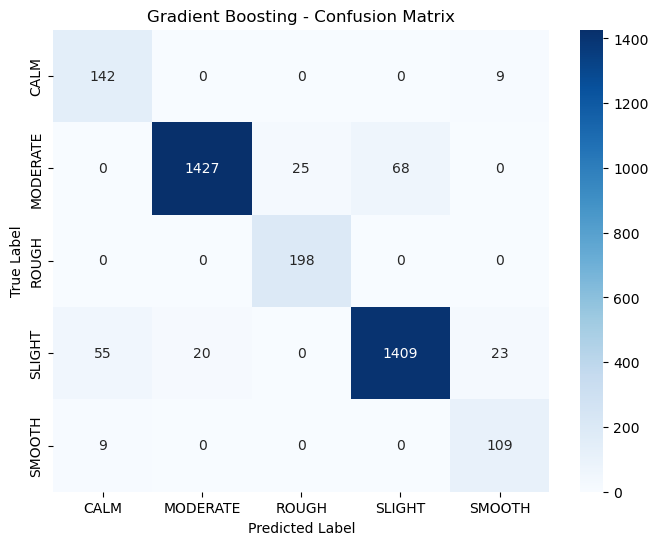

In [84]:
cm_gb = confusion_matrix(y_test, y_pred_gb)

pyp.figure(figsize=(8, 6))
sbn.heatmap(cm_gb, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
pyp.title('Gradient Boosting - Confusion Matrix')
pyp.ylabel('True Label')
pyp.xlabel('Predicted Label')
pyp.show()

This modeled performed better, but still struggles in similar areas as the Linear Classifier. This model is still getting confused between slight and moderate and between slight and smooth.

### Hyperparameter Tuning

The default hyperparameters are unlikely to be the best. I will search across the most influential hyperparameters:

- `n_estimators`: The number of boosting stages (trees) to build. More trees can improve performance but may lead to overfitting.
- `learning_rate`: The step size for updating weights in each boosting iteration. Lower values make learning more gradual and reduce the risk of overfitting.
- `max_depth`: The maximum depth of each decision tree. Deeper trees capture more complex patterns but increase the risk of overfitting.
- `min_samples_split`: The minimum number of samples required to split a node. Higher values make the model more conservative, preventing overfitting.

I will perform a **grid search** to find the optimal combination of these parameters.

**WARNING**: this cell make take a while to run.\
**EDIT**: To reduce the computation time of this cell, I'm instead using a random grid search with less cross-validation folds.

In [85]:
# Define the model
gb_model = GradientBoostingClassifier()

# Define the hyperparameters for grid search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

# Set up the GridSearchCV
grid_search = RandomizedSearchCV(estimator=gb_model, 
                           param_distributions=param_grid, 
                           n_iter=20,
                           cv=3, 
                           scoring='accuracy', 
                           n_jobs=-1, 
                           verbose=2,
                           random_state=42)

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=5, n_estimators=100; total time=   3.1s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END learning_rate=0.01, max_depth=7, min

In [86]:
y_pred = grid_search.predict(X_test)

In [87]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

In [88]:
print(f"Precision (weighted): {precision}")
print(f"Recall (weighted): {recall}")
print(f"F1 Score (weighted): {f1}")

Precision (weighted): 0.9471378115073927
Recall (weighted): 0.9401831711505438
F1 Score (weighted): 0.9419041713870797


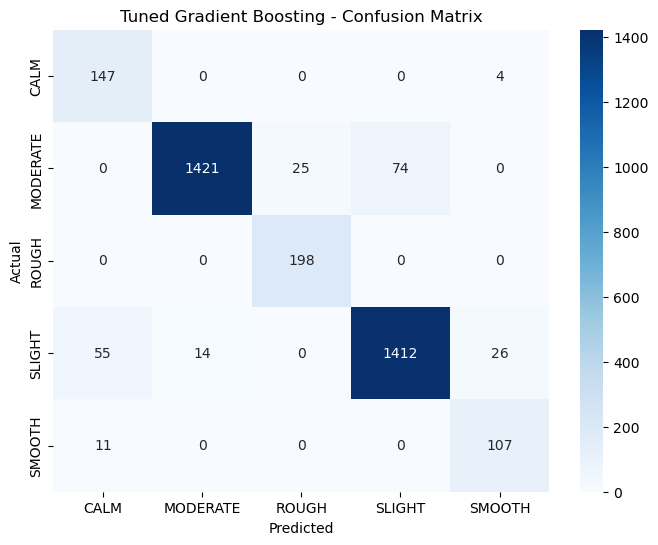

In [89]:
pyp.figure(figsize=(8, 6))
sbn.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
pyp.title('Tuned Gradient Boosting - Confusion Matrix')
pyp.xlabel('Predicted')
pyp.ylabel('Actual')
pyp.show()

## Support Vector Classification (SVC)

Even with hyperparameter tuning, the GB model still is having problems with the same categories. I'll finally try an SVM classification model. This model might be advantageous because of it's unique kernels which helps it handle non-linear data.

### Training

In [90]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

### Predicting

In [91]:
y_pred = svm_model.predict(X_test)

### Evaluation

In [92]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

/Users/colin_beyers@mines.edu/miniconda3/envs/test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [93]:
print("Precision (weighted):", precision)
print("Recall (weighted):", recall)
print("F1 Score (weighted):", f1)

Precision (weighted): 0.8182714237289909
Recall (weighted): 0.8405838580423584
F1 Score (weighted): 0.8261916725960328


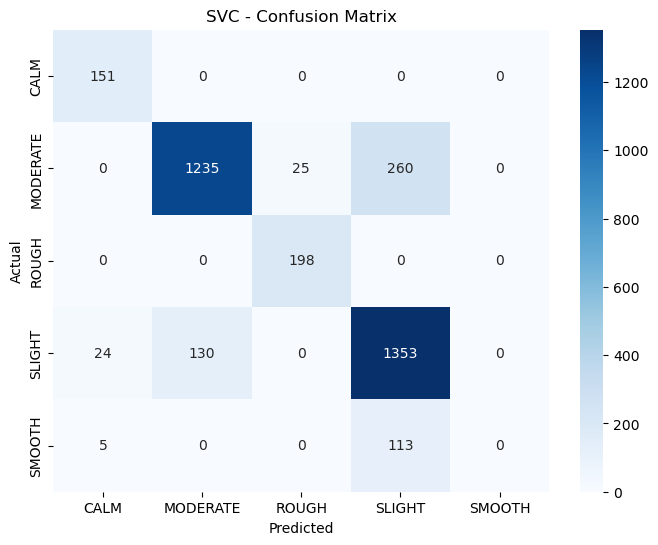

In [94]:
pyp.figure(figsize=(8, 6))
sbn.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
pyp.title('SVC - Confusion Matrix')
pyp.xlabel('Predicted')
pyp.ylabel('Actual')
pyp.show()

### Hyperparameter Tuning

Again, the default parameters are likely not ideal. I will test the following parameters:

- `kernel`: Defines the function used to map data into a higher-dimensional space. Common options include `'linear'`, `'poly'`, `'rbf'`, and `'sigmoid'`. The choice affects the model's ability to capture complex patterns.
- `C`: The regularization parameter, which controls the trade-off between achieving a low error and maintaining a simple decision boundary. Higher values make the model more sensitive to training data.
- `gamma`: Controls the influence of a single training example. Higher values lead to more complex decision boundaries, while lower values create a smoother model.

I will perform a **grid search** to find the optimal combination of these parameters.

**Note**: This grid search was not changed because it is taking me > 1 min to run.

In [95]:
# Define the parameter grid for grid search
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Initialize the SVC model
svc = SVC()

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best parameters found by GridSearchCV:", best_params)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.6s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.2s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.4s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.4s
[CV] END .....................C=0.1, gamma=scal

In [96]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [97]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

In [98]:
print("Precision (weighted):", precision)
print("Recall (weighted):", recall)
print("F1 Score (weighted):", f1)

Precision (weighted): 0.948120124402448
Recall (weighted): 0.9427590154550658
F1 Score (weighted): 0.9443054734718676


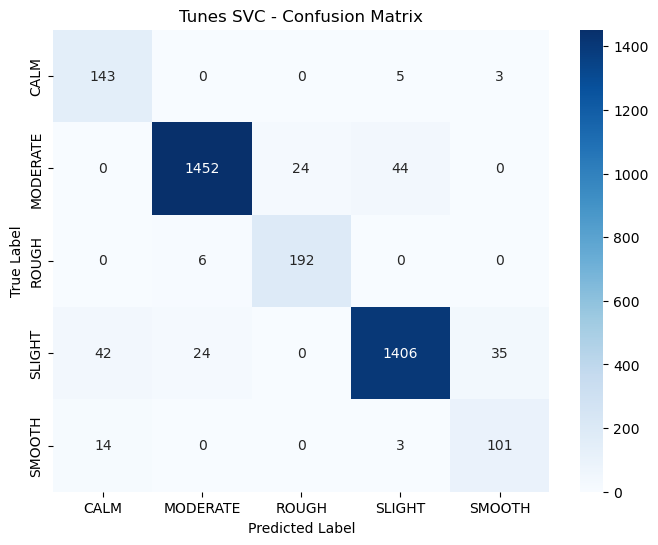

In [99]:
pyp.figure(figsize=(8, 6))
sbn.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
pyp.title('Tunes SVC - Confusion Matrix')
pyp.ylabel('True Label')
pyp.xlabel('Predicted Label')
pyp.show()

Again, we're seeing the same problem persist. It is likely not the model or the parameters, but how I'm choosing training and testing data.

# Addressing the Imbalanced Classes

Thomas gave a suggestion to add a custom penalty matrix. After reading up a bit, it seems that adding a penalty matrix would require me to change the loss function. I tried playing around with this a litter but could not get it to work. Another idea I saw was to use custom class weights. While I could (and tried) coming up with my own class weights, these weights can be estimated based off the class distribution in the training data. However, this calculation does not need to be done by hand, as it can be calculated behind the scenes by passing the `class_weight = 'balanced'` arg to some `scikitlearn` models. I will use my best SVC model because of how that model balanced performance and computation time.

In [116]:
# Define the best hyperparameters found by GridSearchCV
best_params = {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [157]:
# Instantiate the SVC model with the best parameters and custom class weights
svc_model = SVC(C=best_params['C'], 
                gamma=best_params['gamma'], 
                kernel=best_params['kernel'],
                class_weight='balanced')
# Fit the model to your data
svc_model.fit(X_train, y_train)

SVC(C=10, class_weight='balanced', gamma=1)

In [158]:
y_pred = svc_model.predict(X_test)

In [159]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

In [160]:
print("Precision (weighted):", precision)
print("Recall (weighted):", recall)
print("F1 Score (weighted):", f1)

Precision (weighted): 0.9412059794675812
Recall (weighted): 0.9290211791642816
F1 Score (weighted): 0.9323783148867689


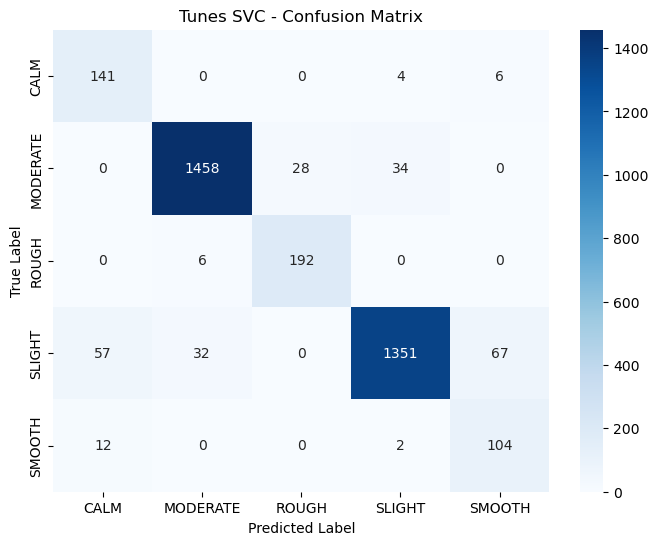

In [161]:
pyp.figure(figsize=(8, 6))
sbn.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
pyp.title('Tunes SVC - Confusion Matrix')
pyp.ylabel('True Label')
pyp.xlabel('Predicted Label')
pyp.show()

Even when balancing the classes with optimal weights, the model still struggles in the same areas. It is likely that a custom penalty matrix would be able to address this issue, as it can address specific types of misclassifications (like the many instances where the model classifies a SLIGHT sea as a SMOOTH sea), but unfortunately I can't get that to work within the time constraints.

## Discussion

### Which method did you like the most?

I think the GB and SVM are the most promising. I liked them because they had hyperparameters that I could tune to fit the needs of my data better. Each also had a distinct advantage: GB is an ensemble approach, and SVM has custom kernels.

### Which method did you like the least?

I like logistical regression the least. While it was simple to set up and really fast, there are no hyperparameters to tune so it was hard to improve results.

### How did you score these supervised models?

I use precision, recall, F1, and confusion matrices.

### Did the output align with your geologic (oceanographic) understanding?

I think each models confusion between slight and moderate is understandable from an oceanographic perspective. While rough seas and extremely calm seas are likely east to characterize because they have distinct characteristics that define them, the "middle-of-the-road" seastates like moderate and slight are probably less distinct, which is supported by how each model struggled with them.

### Did you hyperparameter tune? Why or why not?

Yes, I did hyperparameter tuning for the GB and SVM models. The default settings (or any initial settings I may guess) for either model are very unlikely to be the ones that provide the best fit. Grid searching is a good method for systematically testing for different hyperparameters without having to run them all manually, which is why I used it.

### How did you split your data? Why does that make sense for this dataset?

I chose to do a temporal split where I took the first 80% of data (in time order) and used it for training and took the last 20% and set it aside for testing. This was to ensure that my testing set was as independent as possible from my training set and to avoid autocorrelation issues. As with most geophysical data, observations close in time to one another are not independent---they are related to some decorrelation scale. A random split very likely would have put data that is closely correlated in both the training and testing set. Also, using this method of temporal splitting also assessed how my model was able to generalize. As I had 1 year of data, the last 20% of data was from the winter months of 2023. Wave conditions are not the same all year round (and are highly seasonal), so using data from a different season assessed how well the model was able to generalize to new conditions.

### What did you want to learn more about?

I think the problem I was having with the moderate and slight categories has to do with the fact that my labels are highly imbalanced. I think for my final version, I want to play around with either a) finding ways to rebalance my datasets; or b) finding a way to penalize models more during training when they misclassify a minority label/award them for classifying one correctly.

### Did you pre-process your data?

Yes. I had to:
- Remove unused features
- Rename columns to make them more intuitive
- Parse the native timestamps to datetime objects
- Remove bad data
- Scale my features
- Encode my labels to a number
- Split my data into training and testing sets

### Do all models require pre-processing? 

In my opinion, yes---all models require some level of preprocessing. On a higher level, things like missing data (NaNs or set to 99, like in this case) or data that is not formatted in an intuitive way (like the timestamps in this dataset) can make the modeling process needlessly confusing, can drastically skew results, or can altogether make a model fail. More specifically, things like thoughtful train-test splitting and scaling features are subtle steps but ensure that a model is robust and not misleading or inaccurate.